# AutoEncoder

In [1]:
import tensorflow.keras as k
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model
from data_util import *

## Hyper parameters

In [2]:
input_shape = (28, 28)
hidden_unit = 128
batch_size = 128
noise_factor = 0.3
epochs = 5
num_classes = 10

## Dataset

In [4]:
(x_train, y_train), (x_test, y_test) = load_mnist()

x_train: (60000, 28, 28)
y_train: (60000, 10)
x_test: (10000, 28, 28)
y_test: (10000, 10)


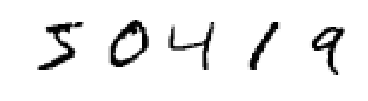

In [21]:
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
show_mnist(x_train[:5])

### Add Noise

In [23]:
x_train_noisy = sap_noise(x_train, 0.2)

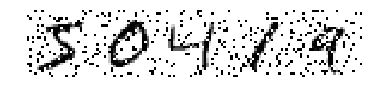

In [22]:
show_mnist(x_train_noisy[:5])

### Show dataset

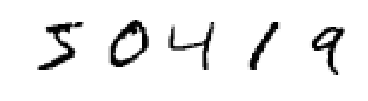

In [24]:
show_mnist(x_train[:5])

## Hyper parameters

In [23]:
input_shape = (28, 28)
hidden_unit = 128
batch_size = 64

## Model --- Denoising Autoencoder

### AutoEncoder = Encoder + Decoder

In [25]:
autoencoder = k.models.load_model('models/dae.h5')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_input (InputLayer)    (None, 28, 28)            0         
_________________________________________________________________
encoder (Model)              (None, 128)               100480    
_________________________________________________________________
decoder (Model)              (None, 28, 28)            101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________


### Reconstruct

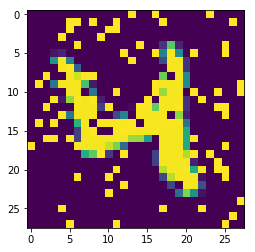

In [26]:
plt.imshow(x_train_noisy[20])

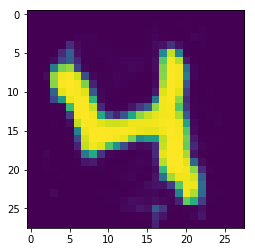

In [27]:
decoded = autoencoder.predict(x_train[20].reshape(1,28,28))
decoded = decoded.reshape(28,28)
plt.imshow(decoded)

## Model --- NN Classifier

### Model with BN and unnormalized data

In [2]:
classifier = k.models.load_model('models/classifier_bn.h5')
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28)            0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
__________

In [ ]:
def evaluate_acc(model):
    hists = []
    for i in range(10):
        noise_level = i / 10
        x_test_noise = sap_noise(x_test, noise_level)
        hist = model.evaluate(x_test_noise, y_test, verbose=0)
        title = "noise level:" + str(noise_level) + "\tAccuracy:" + str(hist[1])
        hists.append(hist)
    hists = np.array(hists)
    return hists

In [ ]:
classifier_hists = evaluate_acc(classifier)
plt.plot(np.linspace(0,100,num=10),classifier_hists[:,1]*100, "-o")
plt.xlabel('Noise level(%)')
plt.ylabel('Accuracy(%)')
plt.title("Predict with Gauusian Noise", fontsize=14)

## Denoise and Classify Model


**Predict Process:** Image + Noise ==> Denoise Autoencoer ==> NN classifier  

**Note** : 
- The Denoise Autoencoder and NN classifier are Trained **separated**.
- The NN classifier has BatchNormailize Layer.
- The data is **NOT** Normalized before train this classifier.

In [35]:
x_input  = k.layers.Input((28,28), name = "Model_Input")
denoise_classifier = Model(x_input, classifier(autoencoder(x_input)), name="denoiseclassifier")
denoise_classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Model_Input (InputLayer)     (None, 28, 28)            0         
_________________________________________________________________
autoencoder (Model)          (None, 28, 28)            201616    
_________________________________________________________________
nnclassifier (Model)         (None, 10)                206666    
Total params: 408,282
Trainable params: 406,714
Non-trainable params: 1,568
_________________________________________________________________


In [36]:
denoise_classifier.compile(loss = "categorical_crossentropy",
                  optimizer="adam",
                  metrics = ['accuracy'],
                  )

### Save Model

In [35]:
denoise_classifier.save('models/separated_dae_nn.h5')

### Predict with Noise

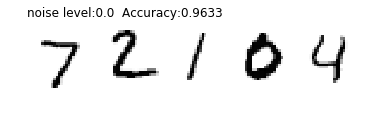

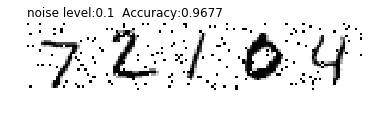

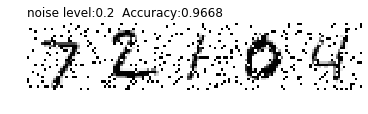

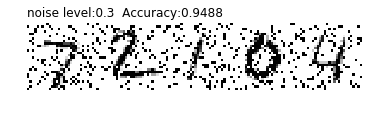

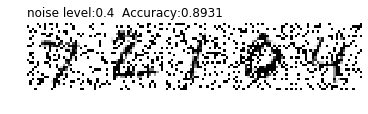

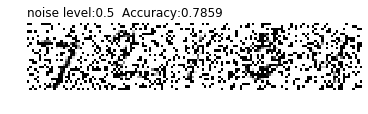

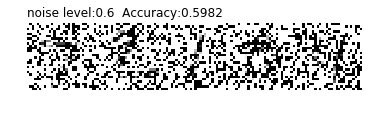

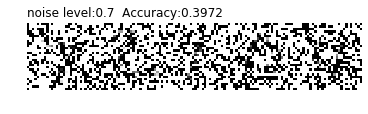

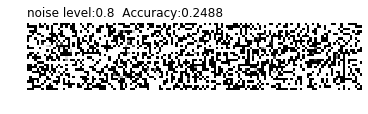

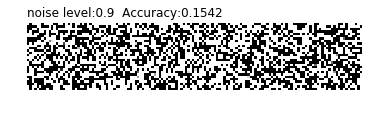

In [38]:
hists2 = []
for i in range(10):
    noise_level = i / 10
    x_test_noise = sap_noise(x_test, noise_level)
    hist = denoise_classifier.evaluate(x_test_noise, y_test, verbose=0)
    title = "noise level:" + str(noise_level) + "  Accuracy:" + str(hist[1])
    show_mnist(x_test_noise[:5], title=title, loc = "left")
    hists2.append(hist)

Text(0.5, 1.0, 'Predict with Gauusian Noise')

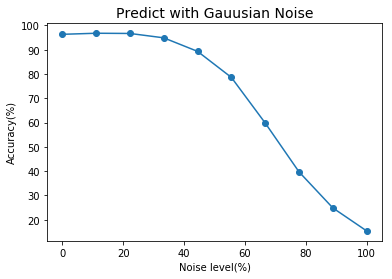

In [40]:
hists2 = np.array(hists2)
plt.plot(np.linspace(0,100,num=10),hists2[:,1]*100, "-o")
plt.xlabel('Noise level(%)')
plt.ylabel('Accuracy(%)')
plt.title("Predict with Gauusian Noise", fontsize=14)

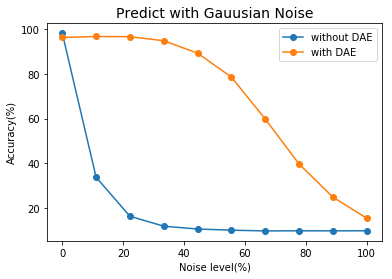

In [41]:
plt.plot(np.linspace(0,100,num=10),hists1[:,1]*100, "-o", label="without DAE")
plt.plot(np.linspace(0,100,num=10),hists2[:,1]*100, "-o", label="with DAE")
plt.xlabel('Noise level(%)')
plt.ylabel('Accuracy(%)')
plt.title("Predict with Gauusian Noise", fontsize=14)
plt.legend()
plt.show()

## Model --- NN Classifier without BN layer

### Model without BN

In [42]:
classifier = k.models.load_model('models/classifier_without_bn.h5')
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28)            0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
_________________________________________________________________
output (Activation)          (None, 10)                0         
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


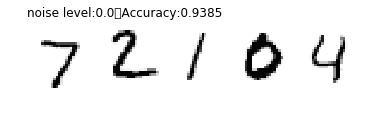

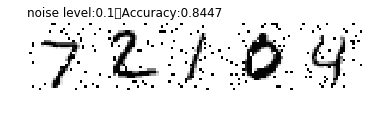

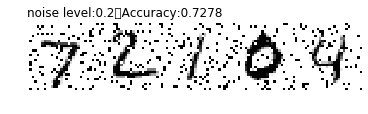

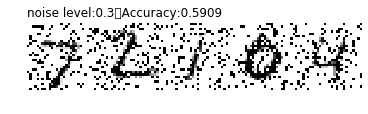

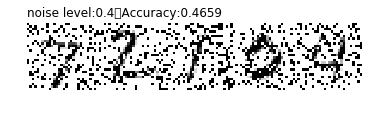

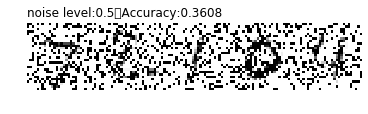

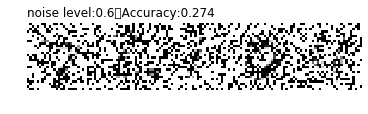

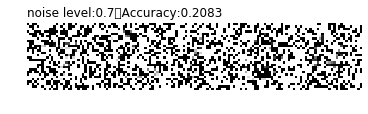

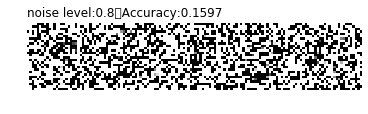

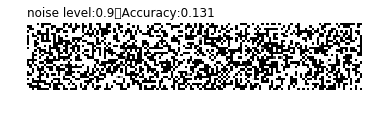

In [43]:
hists1 = []
for i in range(10):
    noise_level = i / 10
    x_test_noise = sap_noise(x_test, noise_level)
    hist = classifier.evaluate(x_test_noise, y_test, verbose=0)
    title = "noise level:" + str(noise_level) + "\tAccuracy:" + str(hist[1])
    show_mnist(x_test_noise[:5], title=title, loc = "left")
    hists1.append(hist)

Text(0.5, 1.0, 'Predict with Gauusian Noise')

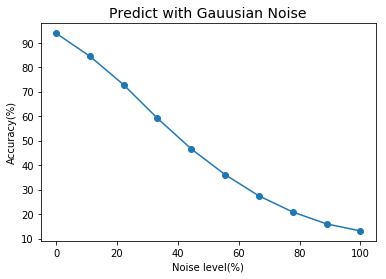

In [44]:
hists1= np.array(hists1)
plt.plot(np.linspace(0,100,num=10),hists1[:,1]*100, "-o")
plt.xlabel('Noise level(%)')
plt.ylabel('Accuracy(%)')
plt.title("Predict with Gauusian Noise", fontsize=14)

## Denoise and Classify Model -- without BN


**Predict Process:** Image + Noise ==> Denoise Autoencoer ==> NN classifier  

**Note** : 
- The Denoise Autoencoder and NN classifier are Trained **separated**.
- The NN classifier don't have BatchNormailize Layer.
- The data is **Normalized** before train this classifier.
- The data with Noise is **NOT** Normalized befor put in this model.

In [46]:
x_input  = k.layers.Input((28,28), name = "Model_Input")
denoise_classifier = Model(x_input, classifier(autoencoder(x_input)))
denoise_classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Model_Input (InputLayer)     (None, 28, 28)            0         
_________________________________________________________________
autoencoder (Model)          (None, 28, 28)            201616    
_________________________________________________________________
nnclassifier (Model)         (None, 10)                203530    
Total params: 405,146
Trainable params: 405,146
Non-trainable params: 0
_________________________________________________________________


In [47]:
denoise_classifier.compile(loss = "categorical_crossentropy",
                  optimizer="adam",
                  metrics = ['accuracy'],
                  )

### Save Model

In [55]:
denoise_classifier.save('models/separated_dae_nn_without_bn.h5')

### Predict with Noise

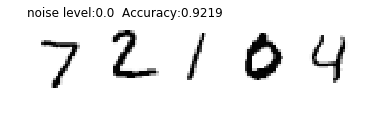

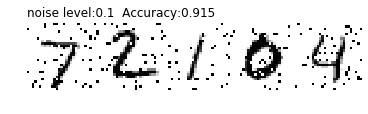

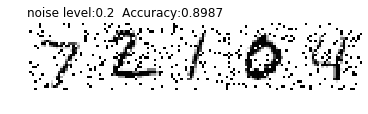

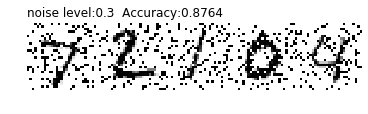

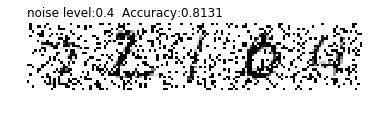

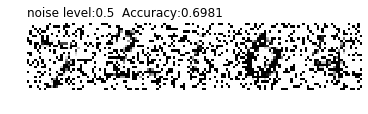

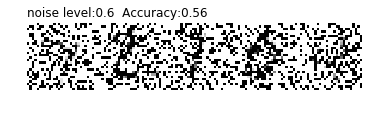

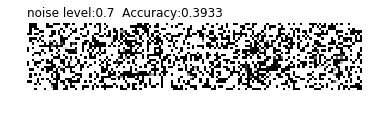

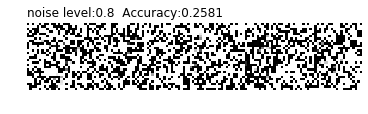

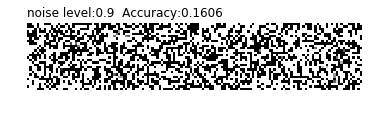

In [49]:
hists2 = []
for i in range(10):
    noise_level = i / 10
    x_test_noise = sap_noise(x_test, noise_level)
    hist = denoise_classifier.evaluate(x_test_noise, y_test, verbose=0)
    title = "noise level:" + str(noise_level) + "  Accuracy:" + str(hist[1])
    show_mnist(x_test_noise[:5], title=title, loc = "left")
    hists2.append(hist)

Text(0.5, 1.0, 'Predict with Gauusian Noise')

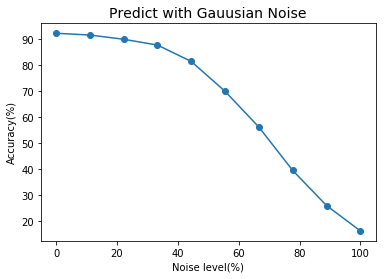

In [50]:
hists2 = np.array(hists2)
plt.plot(np.linspace(0,100,num=10),hists2[:,1]*100, "-o")
plt.xlabel('Noise level(%)')
plt.ylabel('Accuracy(%)')
plt.title("Predict with Gauusian Noise", fontsize=14)

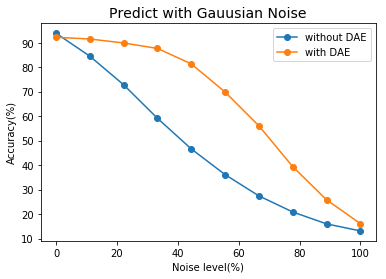

In [51]:
plt.plot(np.linspace(0,100,num=10),hists1[:,1]*100, "-o", label="without DAE")
plt.plot(np.linspace(0,100,num=10),hists2[:,1]*100, "-o", label="with DAE")
plt.xlabel('Noise level(%)')
plt.ylabel('Accuracy(%)')
plt.title("Predict with Gauusian Noise", fontsize=14)
plt.legend()
plt.show()